### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras.models import *
from keras.layers import *

data_path_mini = '../data/raw/kaggle_mini_subsample'
data_path_train = '../data/raw/kaggle/train'
data_path_val = '../data/raw/kaggle/val'

### Mini dataset

Found 500 images belonging to 2 classes.


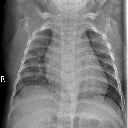

{'NORMAL': 0, 'PNEUMONIA': 1}


In [2]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]
image_generator = ImageDataGenerator().flow_from_directory(data_path_mini, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display(array_to_img(images[0]))
print(image_generator.class_indices)

In [4]:
x = images_scaled.reshape(250,128*128*3)

SHAPE = (x.shape[1],)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape = SHAPE))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
history = model.fit(x=x, y=labels, epochs=50)

Epoch 1/50
8/8 [==============================] - 0s 14ms/step - loss: 2.8369 - accuracy: 0.5640
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6801 - accuracy: 0.5560
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6599 - accuracy: 0.5960
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6540 - accuracy: 0.7440
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6581 - accuracy: 0.5480
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6107 - accuracy: 0.6160
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6586 - accuracy: 0.6520
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5272 - accuracy: 0.7640
Epoch 9/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6692 - accuracy: 0.6960
Epoch 10/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5835 - accuracy: 0.7120
Epoch 11/50
8/8 [============

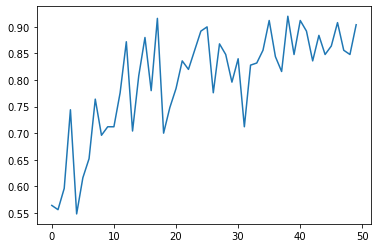

In [8]:
acc = history.history['accuracy']
plt.plot(range(len(acc)), acc);

### Full train dataset, no separate validation dataset used

In [9]:
BATCH_SIZE_TRAIN = 1341+3875
BATCH_SIZE_VAL = 8+8
TARGET_SIZE = [128, 128]

generator_train = ImageDataGenerator().flow_from_directory(data_path_train,
                                                          batch_size=BATCH_SIZE_TRAIN,
                                                          target_size=TARGET_SIZE)
generator_val = ImageDataGenerator().flow_from_directory(data_path_val,
                                                        batch_size=BATCH_SIZE_VAL,
                                                        target_size=TARGET_SIZE)

images_train, labels_train = next(generator_train)
images_val, labels_val = next(generator_val)

print(images_train.shape, labels_train.shape)
print(images_val.shape, labels_val.shape)

images_train_scaled = images_train / 256
images_val_scaled = images_val / 256

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
(5216, 128, 128, 3) (5216, 2)
(16, 128, 128, 3) (16, 2)


In [10]:
s = images_train.shape
x = images_train_scaled.reshape(s[0], s[1]*s[2]*s[3])

SHAPE = (x.shape[1],)

print(x.shape, labels_train.shape, SHAPE)

(5216, 49152) (5216, 2) (49152,)


In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape = SHAPE))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(x=x, y=labels_train, epochs=100, validation_split=0.4)

Epoch 1/100
98/98 [==============================] - 7s 76ms/step - loss: 0.6747 - accuracy: 0.7510 - val_loss: 0.4673 - val_accuracy: 0.8586
Epoch 2/100
98/98 [==============================] - 3s 34ms/step - loss: 0.3953 - accuracy: 0.8233 - val_loss: 0.7156 - val_accuracy: 0.7547
Epoch 3/100
98/98 [==============================] - 3s 32ms/step - loss: 0.3246 - accuracy: 0.8639 - val_loss: 0.1929 - val_accuracy: 0.9363
Epoch 4/100
98/98 [==============================] - 3s 32ms/step - loss: 0.2949 - accuracy: 0.8814 - val_loss: 0.2120 - val_accuracy: 0.9051
Epoch 5/100
98/98 [==============================] - 3s 32ms/step - loss: 0.2669 - accuracy: 0.8907 - val_loss: 0.2056 - val_accuracy: 0.9090
Epoch 6/100
98/98 [==============================] - 3s 30ms/step - loss: 0.2383 - accuracy: 0.9016 - val_loss: 0.1709 - val_accuracy: 0.9300
Epoch 7/100
98/98 [==============================] - 3s 31ms/step - loss: 0.2206 - accuracy: 0.9182 - val_loss: 0.2792 - val_accuracy: 0.9396
Epoch 

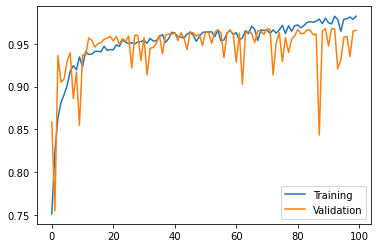

In [13]:
history.history.keys()

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epoch_ct = range(len(acc_train))

plt.plot(epoch_ct, acc_train, label='Training')
plt.plot(epoch_ct, acc_val, label='Validation')
plt.legend();

In [14]:
images_train_scaled = images_train / 256
images_val_scaled = images_val / 256

In [15]:
images_train_scaled.shape, images_val_scaled.shape

((5216, 128, 128, 3), (16, 128, 128, 3))

In [20]:
np.append(images_train, images_val, axis=0).shape

(5232, 128, 128, 3)